# Verwenden statistischer Größen der Zeitreihen als Features

Test SVM-Klassifikation

In [1]:
import io, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
from sklearn import model_selection, metrics, manifold, preprocessing
from tensorflow import keras
import keras_tuner as kt

import prepare

2025-01-10 17:04:55.261924: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-10 17:04:55.357850: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-10 17:04:55.380413: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-10 17:04:55.672308: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
BASE_DIR = 'renamed'
DATA_OK = ['ok', 'near_ok_sonowechsel']
DATA_FEHLER = ['fehler_oel', 'fehler_leitungsversatz', 'fehler_terminversatz']
DATA_ALL = DATA_OK + DATA_FEHLER

In [3]:
DATA_ALL

['ok',
 'near_ok_sonowechsel',
 'fehler_oel',
 'fehler_leitungsversatz',
 'fehler_terminversatz']

In [4]:
zugversuche, kurven = prepare.read_all(BASE_DIR, DATA_ALL)

ok_: count 200 rows 1407...1650
near_ok_sonowechsel_: count 100 rows 1582...1759
fehler_oel_: count 100 rows 1052...1434
fehler_leitungsversatz_: count 100 rows 1716...2403
fehler_terminversatz_: count 100 rows 1702...2092


Debugausgabe

In [5]:
zugversuche

,nr,festigkeit,key,label,label_text
0,1569,2600.000000,ok_1569,0,ok
1,1570,2750.000000,ok_1570,0,ok
2,1571,2770.000000,ok_1571,0,ok
3,1572,2660.000000,ok_1572,0,ok
4,1573,2810.000000,ok_1573,0,ok
...,...,...,...,...,...
595,2505,1479.522827,fehler_terminversatz_2505,4,fehler_terminversatz
596,2506,2085.117920,fehler_terminversatz_2506,4,fehler_terminversatz
597,2507,2237.231201,fehler_terminversatz_2507,4,fehler_terminversatz
598,2508,2406.469482,fehler_terminversatz_2508,4,fehler_terminversatz


In [17]:
versuche_train_valid, versuche_test = model_selection.train_test_split(zugversuche, test_size=0.2, random_state=42)
versuche_train, versuche_valid = model_selection.train_test_split(versuche_train_valid, test_size=0.1, random_state=42)
versuche_train.shape, versuche_valid.shape, versuche_test.shape

((432, 5), (48, 5), (120, 5))

Umwandeln in statistische Features

In [18]:
stat_feat = prepare.StatFeatures()
stat_feat.fit() # dummy

StatFeatures()

In [19]:
X_train = stat_feat.transform(versuche_train.key, kurven)
label_train = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values
print(X_train.shape, label_train.shape)

(432, 13) (432,)


In [20]:
X_valid = stat_feat.transform(versuche_valid.key, kurven)
label_valid = versuche_valid.label.values
festigkeit_valid = versuche_valid.festigkeit.values
print(X_valid.shape)
print(X_valid.max(axis=(0,1)))
#festigkeit_train

(48, 13)
3528.03


In [21]:
X_test = stat_feat.transform(versuche_test.key, kurven)
label_test = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values
print(X_test.shape)
print(X_test.max(axis=(0,1)))
#festigkeit_train

(120, 13)
3551.38


Skalieren Trainingsdaten

In [22]:
std_scaler = preprocessing.StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)

In [23]:
X_valid_scaled = std_scaler.transform(X_valid)

Skalieren Testdaten

In [24]:
X_test_scaled = std_scaler.transform(X_test)

Kontrollanzeige t-SNE

In [25]:
X_train_projected = manifold.TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_train_scaled)

Text(0.5, 1.0, '2-D-Projektion Zeitreihe Power (t-SNE): Klassen')

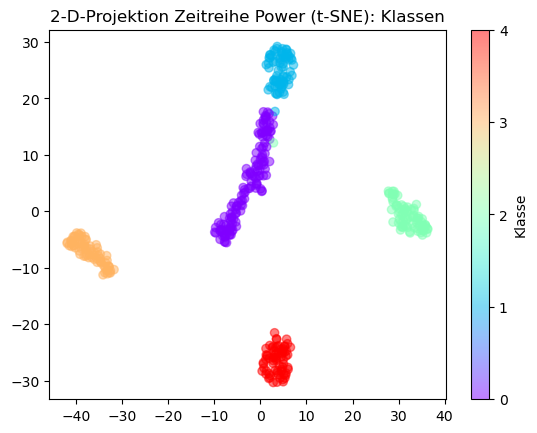

In [26]:
plt.scatter(X_train_projected[:,0], X_train_projected[:,1], c=label_train, cmap='rainbow', alpha=0.5)
plt.colorbar(label='Klasse', ticks=[0,1,2,3,4,5])
plt.title('2-D-Projektion Zeitreihe Power (t-SNE): Klassen')

Text(0.5, 1.0, '2-D-Projektion Zeitreihe Power (t-SNE): Festigkeit')

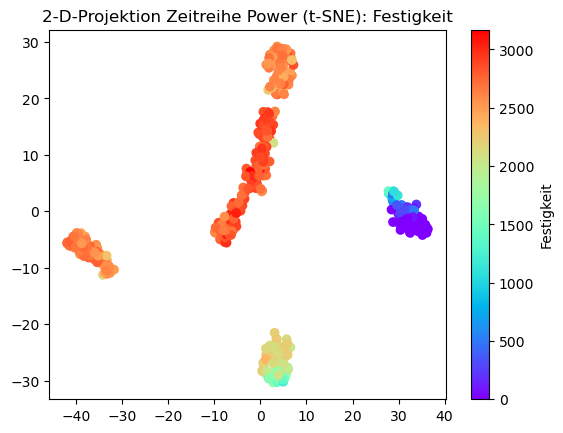

In [27]:
plt.scatter(X_train_projected[:,0], X_train_projected[:,1], c=festigkeit_train, cmap='rainbow')
plt.colorbar(label='Festigkeit')
plt.title('2-D-Projektion Zeitreihe Power (t-SNE): Festigkeit')

Hyperparameter FFN

In [52]:
def build_reg(hp):
    n_hidden = hp.Int("n_hidden", min_value=1, max_value=6, default=2)
    n_neurons = hp.Int("n_neurons", min_value=32, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=5e-3, sampling='log')
    return build_reg_param(n_hidden, n_neurons, learning_rate)

def build_reg_param(n_hidden, n_neurons, learning_rate):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=X_train_scaled.shape[1:]))
    for _ in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, kernel_initializer='he_normal', use_bias=False))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dense(1, activation='relu')) # combine outputs
    model.add(keras.layers.Lambda(lambda x: x*2000.0)) # scale
    model.compile(
        loss='mse',
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    )
    return model


In [53]:
random_search_tuner = kt.RandomSearch(
    build_reg, objective='val_loss', max_trials=10,
    overwrite=True, directory='ann1', project_name='ann1_reg',
    seed=42)
random_search_tuner.search(X_train_scaled, festigkeit_train, epochs=30,
    batch_size=16,
    validation_data=(X_valid_scaled, festigkeit_valid)
)

Trial 10 Complete [00h 00m 09s]
val_loss: 40736.38671875

Best val_loss So Far: 20041.630859375
Total elapsed time: 00h 01m 09s


In [54]:
hp = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]
hp.values

{'n_hidden': 2, 'n_neurons': 143, 'learning_rate': 0.0037725050925118946}

Bestes Modell manuell nachbauen

In [56]:
model_reg = build_reg_param(2, 143, 0.004)
hist = model_reg.fit(X_train_scaled, festigkeit_train, epochs=30,
              batch_size=16,
              validation_data=(X_valid_scaled, festigkeit_valid),
            )
                     

Epoch 1/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 2579573.0000 - val_loss: 4196007.5000
Epoch 2/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 713232.1250 - val_loss: 1824189.0000
Epoch 3/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 494080.4062 - val_loss: 1463926.5000
Epoch 4/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131025.1094 - val_loss: 440602.8438
Epoch 5/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88326.9766 - val_loss: 285890.4062
Epoch 6/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144493.6094 - val_loss: 260813.9219
Epoch 7/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129353.3750 - val_loss: 161151.3594
Epoch 8/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145457.2812 - val_loss: 147559.2500
Epoch 9/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 139332.3281 - val_loss: 126374.6875
Epoch 10/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82236.8750 - val_loss: 234276.4844
Epoch 11/30
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

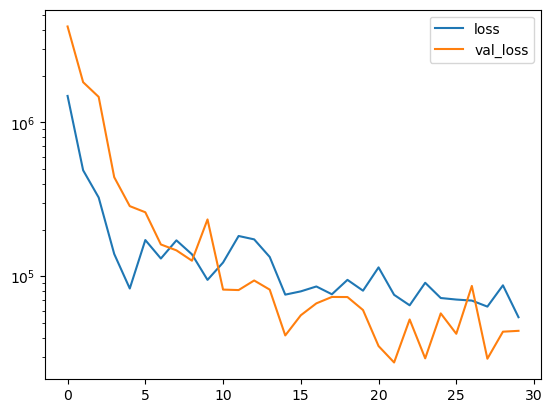

In [60]:
pd.DataFrame(hist.history).plot(logy=True)
plt.show()

Beobachtung: 10 bis 20 Epochen reichen aus.

Vorhersage Trainingsdaten

In [61]:
model_reg = random_search_tuner.get_best_models(num_models=1)[0]
model_reg.summary()

/opt/miniconda3/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 143)            │         1,859 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 143)            │           572 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 143)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 143)            │        20,449 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 143)            │           572 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 143)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lambda (Lambda)                 │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,596 (92.17 KB)

 Trainable params: 23,024 (89.94 KB)

 Non-trainable params: 572 (2.23 KB)

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step


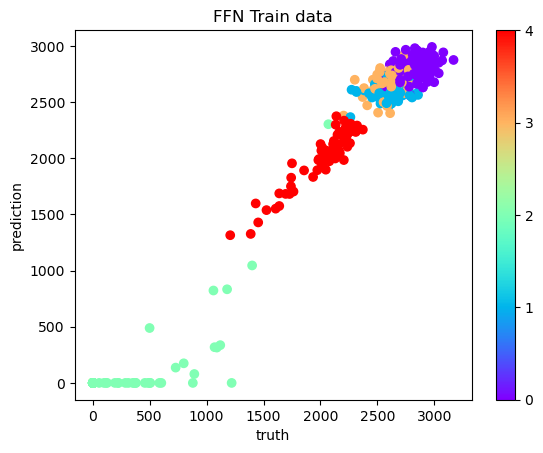

In [62]:
y_pred_train = model_reg.predict(X_train_scaled)
plt.scatter(festigkeit_train, y_pred_train, c=label_train, cmap='rainbow')
plt.title('FFN Train data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))

Vorhersage Testdaten

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step

2025-01-10 17:28:14.928496: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_38', 20 bytes spill stores, 20 bytes spill loads



4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 876ms/step


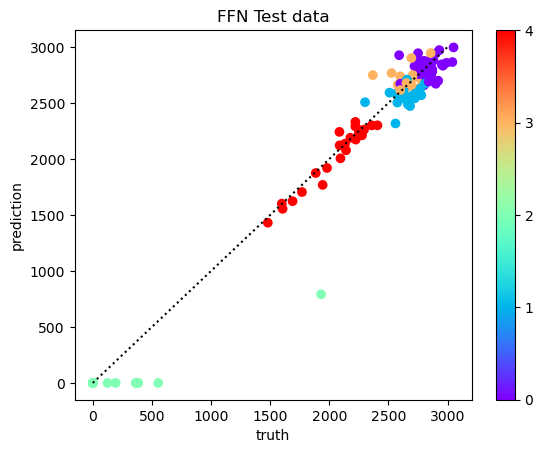

In [63]:
y_pred_test = model_reg.predict(X_test_scaled)
plt.plot((0, 3000), (0, 3000), 'k:')
plt.scatter(festigkeit_test, y_pred_test, c=label_test, cmap='rainbow')
plt.title('FFN Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))

In [64]:
mse_train = metrics.mean_squared_error(festigkeit_train, y_pred_train)
mse_test = metrics.mean_squared_error(festigkeit_test, y_pred_test)
print(f"MSE: train {mse_train:8.1f}, test: {mse_test:8.1f}")
print(f"RMSE: train {np.sqrt(mse_train):8.1f} test: {np.sqrt(mse_test):8.1f}")
mae_train = metrics.mean_absolute_error(festigkeit_train, y_pred_train)
mae_test = metrics.mean_absolute_error(festigkeit_test, y_pred_test)
print(f"MAE: train {mae_train:8.1f}, test: {mae_test:8.1f}")


MSE: train  31639.0, test:  28973.4
RMSE: train    177.9 test:    170.2
MAE: train    112.5, test:    104.2
